In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

### Loading Data

In [6]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [7]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [4]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


(28, 28)


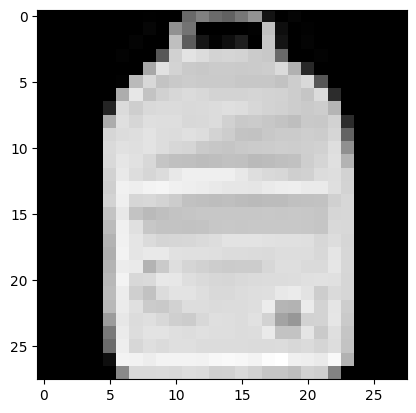

In [5]:
example_image = next(iter(training_data))[0].squeeze().numpy()
plt.imshow(example_image, cmap='gray')
print(example_image.shape)

### CNN Baseline Model
Model with two CNN layers (including max pooling), one dense and an output classification layer, with suitable number of filters and units, respectively.

In [2]:
def cnn_model(numFilters=32, filterSize=3):
    """
    Model with two CNN layers, one dense and an output classification layer, with suitable number of filters and units, respectively.
    :return:
    """
    ### YOUR CODE HERE
    model = torch.nn.Sequential(
        torch.nn.Conv2d(
            in_channels=1, 
            out_channels=numFilters, 
            kernel_size=(filterSize, filterSize), 
            padding=filterSize//2
        ), 
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(2,2)),

        torch.nn.Conv2d(
            in_channels=numFilters, 
            out_channels=numFilters*2, 
            kernel_size=(filterSize, filterSize), 
            padding=filterSize//2
        ), 
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(2,2)),

        torch.nn.Flatten(),
        torch.nn.Linear(int(numFilters*2*(28/(2*2))**2), 10) # For numFilter=32: 64*7*7 = 3136; num_classes=10
    )

    ### YOUR CODE HERE
    return model

In [53]:
model = cnn_model()
from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 0.19
Estimated Total Size (MB): 0.86
----------------------------------------------------------------


### Training

Implement the training / evaluation loop
Remember training / validation cost and accuracy per epoch and return them as list.

In [8]:
def train_eval(model, optimizer, nepochs, training_loader, test_loader, scheduler=None):
    """
    Perform training and evaluation loop.
    :param model: Model to be trained
    :param optimizer: Optimiser to use for training
    :param nepochs: Number of epochs
    :param training_loader: Loader to provide mini-batches of training samples
    :param test_loader: Loader to provide mini-batches of validation samples
    :param scheduler: Scheduler used for a learning rate schedule
    :return: Lists with training and validation cost and accuracy per epoch.
    """
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    cost_ce = torch.nn.CrossEntropyLoss()
        
    for epoch in range(nepochs):

        ### YOUR CODE HERE ###
        # Training -----------------------------------------------------------------------------
        agg_loss_train = 0.0    # for cost calc at end of epoch
        agg_correct_train = 0.0 # for accuracy calc at end of epoch
        for batch, (X, Y) in enumerate(training_loader):
            # Actual training
            pred = model(X)
            loss = cost_ce(pred, Y)

            optimizer.zero_grad() # reset gradient accumulation
            loss.backward() # compute gradient in back-prop
            optimizer.step()

            # Track loss and accuracy across batch
            agg_loss_train += loss.item()
            agg_correct_train += (pred.argmax(dim=1) == Y).sum().item()

        # Update evaluation metrics
        cost=agg_loss_train / len(training_loader.dataset)
        acc=agg_correct_train / len(training_loader.dataset)

        # Validation ----------------------------------------------------------------------------
        agg_loss_val = 0.0
        agg_correct_val = 0.0
        with torch.no_grad(): # won't be doing GD on these tensors, so turn off automatic tracking
            for X, Y in test_loader:
                pred = model(X) # pred.shape = (nbatch, 10)

                # Track loss and accuracy across batch
                agg_loss_val += cost_ce(pred, Y).item()
                agg_correct_val += (pred.argmax(dim=1) == Y).sum().item()

        # Update evaluation metrics
        cost_test = agg_loss_val / len(test_loader.dataset)
        acc_test = agg_correct_val / len(test_loader.dataset)

        if scheduler is not None:
            scheduler.step()
        
        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

### Train Baseline CNN Model

Follow the "Steps to Test and Tune a Model" as presented in the lecture.

Train the baseline with SGD without momentum and fixed learning rate. Tune the learning rate by this procedure.

Determine a suitable number of epochs.

#### Test Run: Overfit a small sample

In [10]:
### YOUR CODE HERE ###
# Params
nepochs = 20
nbatch = 32
nbatches = 1  # test run (tiny test sample)

lr = 0.05

model = cnn_model() # reset model
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

trainsize = nbatches*nbatch
training_data_subset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
print(len(training_data_subset), len(rest))

# Data loaders to provide mini-batches of samples
training_loader = DataLoader(training_data_subset, batch_size=nbatch, shuffle=True) 
test_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.5)
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, optimizer, nepochs, training_loader, test_loader)

32 49968
Epoch 0: 0.071942, 0.125000, 0.071626, 0.104200
Epoch 1: 0.069876, 0.125000, 0.071374, 0.171900
Epoch 2: 0.068207, 0.281250, 0.071235, 0.196700
Epoch 3: 0.066672, 0.312500, 0.071162, 0.218000
Epoch 4: 0.065179, 0.343750, 0.071095, 0.235800
Epoch 5: 0.063694, 0.343750, 0.070940, 0.250400
Epoch 6: 0.062171, 0.375000, 0.070669, 0.256100
Epoch 7: 0.060556, 0.406250, 0.070245, 0.257100
Epoch 8: 0.058804, 0.437500, 0.069681, 0.262600
Epoch 9: 0.056872, 0.437500, 0.068915, 0.274000
Epoch 10: 0.054727, 0.437500, 0.068001, 0.288100
Epoch 11: 0.052374, 0.468750, 0.066921, 0.308900
Epoch 12: 0.049822, 0.468750, 0.065733, 0.346300
Epoch 13: 0.047112, 0.500000, 0.064498, 0.400200
Epoch 14: 0.044306, 0.656250, 0.063216, 0.451000
Epoch 15: 0.041476, 0.718750, 0.061993, 0.484500
Epoch 16: 0.038690, 0.718750, 0.060952, 0.508900
Epoch 17: 0.036002, 0.781250, 0.060118, 0.518900
Epoch 18: 0.033466, 0.781250, 0.059528, 0.525500
Epoch 19: 0.031117, 0.781250, 0.059201, 0.523100
Epoch 20: 0.029013, 0

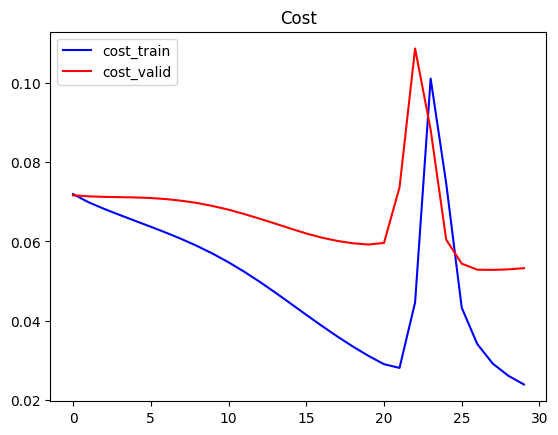

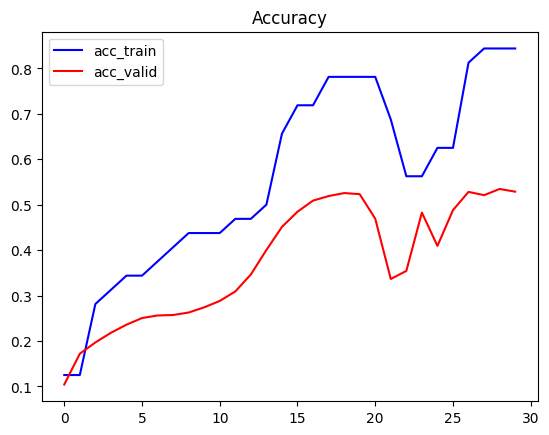

In [12]:
plt.figure(1)
plt.title("Cost")
plt.plot(range(nepochs), cost_train, "b-", label="cost_train")
plt.plot(range(nepochs), cost_valid, "r-", label="cost_valid")
plt.legend()


plt.figure(2)
plt.title("Accuracy")
plt.plot(range(nepochs), acc_train, "b-", label="acc_train")
plt.plot(range(nepochs), acc_valid, "r-", label="acc_valid")
plt.legend()

#### Coarse Grid Search
Try to find a good combination for the parameters
- batch size
- learning rate
- number of filters
- Filter size and padding

Looking at batch size independently first, then grid search for the CNN params

Epoch 0: 0.141003, 0.168750, 0.129535, 0.359500
Epoch 1: 0.119588, 0.356250, 0.113320, 0.358300
Epoch 2: 0.103691, 0.431250, 0.086898, 0.525600
Epoch 3: 0.079821, 0.525000, 0.095640, 0.516300
Epoch 4: 0.072760, 0.606250, 0.074666, 0.543000
Epoch 5: 0.058332, 0.675000, 0.087447, 0.552300
Epoch 6: 0.072098, 0.631250, 0.068857, 0.591600
Epoch 7: 0.056475, 0.700000, 0.065972, 0.662200
Epoch 8: 0.055627, 0.712500, 0.071023, 0.594900
Epoch 9: 0.051836, 0.706250, 0.060298, 0.670300
Epoch 10: 0.048862, 0.743750, 0.067017, 0.594600
Epoch 11: 0.048631, 0.743750, 0.055698, 0.692100
Epoch 12: 0.041233, 0.743750, 0.053000, 0.706000
Epoch 13: 0.043790, 0.737500, 0.062923, 0.609400
Epoch 14: 0.039000, 0.787500, 0.050983, 0.714000
Epoch 15: 0.032973, 0.812500, 0.050979, 0.715300
Epoch 16: 0.042005, 0.756250, 0.051757, 0.711800
Epoch 17: 0.034267, 0.800000, 0.057154, 0.678600
Epoch 18: 0.034937, 0.793750, 0.049567, 0.731900
Epoch 19: 0.037987, 0.787500, 0.051829, 0.707800
Epoch 0: 0.070577, 0.131250, 0

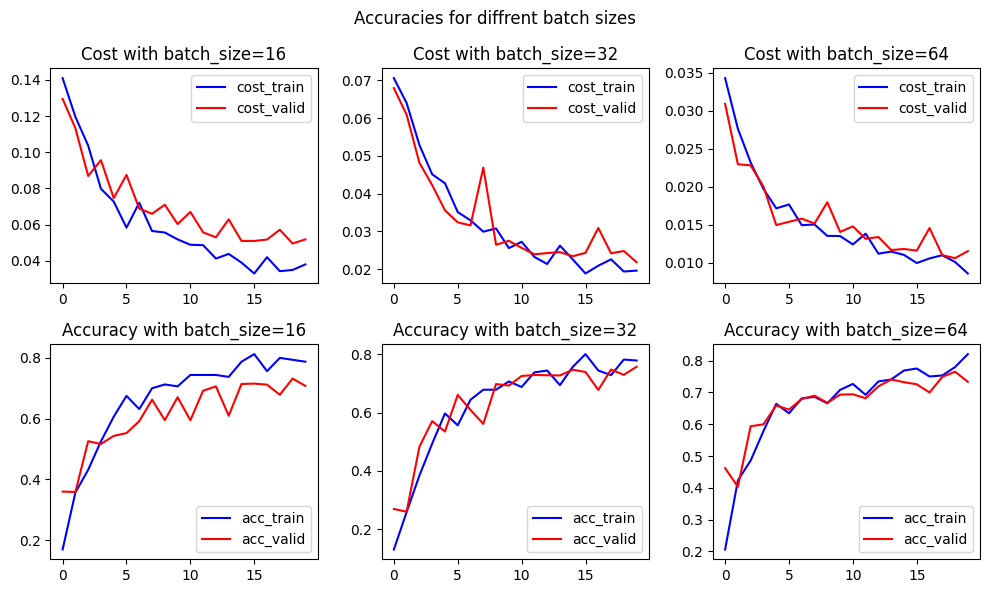

In [35]:
# Params
nepochs = 20
lr = 0.05 # tuned later

batchSize_grid = np.array([16, 32, 64]).astype('int')

fig = plt.figure(figsize=(10,6), tight_layout=True)
fig.suptitle("Accuracies for diffrent batch sizes")
gs = GridSpec(2,3,fig)

for i, batchSize in enumerate(batchSize_grid):
    # train model with grid params
    model = cnn_model()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)

    # Data loaders to provide mini-batches of samples
    nbatches = 10  # small (but not tiny) sample
    trainsize = nbatches*batchSize
    training_data_subset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
    training_loader = DataLoader(training_data_subset, batch_size=batchSize.item(), shuffle=True) 
    test_loader = DataLoader(validation_data, batch_size=batchSize.item(), shuffle=True)
    # NOTE: batchSize.item() to get native 'int' datatype required for batch_size argument

    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, optimizer, nepochs, training_loader, test_loader)

    fig.add_subplot(gs[0, i])
    plt.title("Cost with batch_size={}".format(batchSize))
    plt.plot(range(nepochs), cost_train, "b-", label="cost_train")
    plt.plot(range(nepochs), cost_valid, "r-", label="cost_valid")
    plt.legend()

    fig.add_subplot(gs[1, i])
    plt.title("Accuracy with batch_size={}".format(batchSize))
    plt.plot(range(nepochs), acc_train, "b-", label="acc_train")
    plt.plot(range(nepochs), acc_valid, "r-", label="acc_valid")
    plt.legend()

Choosing batch_size=32: Validation curve follows training curve nicely and going higher doesn't seem necessary. 
(Small batch size preferrable, since less likely to get stuck in local minima)

Epoch 0: 0.071519, 0.168750, 0.070938, 0.210200
Epoch 1: 0.070377, 0.215625, 0.069861, 0.268700
Epoch 2: 0.069080, 0.300000, 0.068561, 0.361100
Epoch 3: 0.067471, 0.428125, 0.066908, 0.419200
Epoch 4: 0.065467, 0.500000, 0.064708, 0.472500
Epoch 5: 0.062815, 0.534375, 0.061823, 0.490000
Epoch 6: 0.059307, 0.531250, 0.058131, 0.494200
Epoch 7: 0.055109, 0.571875, 0.053751, 0.482300
Epoch 8: 0.050179, 0.590625, 0.048822, 0.548500
Epoch 9: 0.045110, 0.609375, 0.044712, 0.552900
Epoch 10: 0.041301, 0.596875, 0.041015, 0.577000
Epoch 11: 0.038094, 0.590625, 0.038239, 0.602900
Epoch 12: 0.035305, 0.625000, 0.035106, 0.637800
Epoch 13: 0.032815, 0.646875, 0.033436, 0.657000
Epoch 14: 0.030841, 0.678125, 0.032318, 0.631300
Epoch 15: 0.029331, 0.668750, 0.031371, 0.649400
Epoch 16: 0.028476, 0.690625, 0.029624, 0.674600
Epoch 17: 0.027739, 0.690625, 0.030298, 0.634200
Epoch 18: 0.028228, 0.650000, 0.030737, 0.633900
Epoch 19: 0.026794, 0.687500, 0.028700, 0.657700
Epoch 0: 0.069484, 0.171875, 0

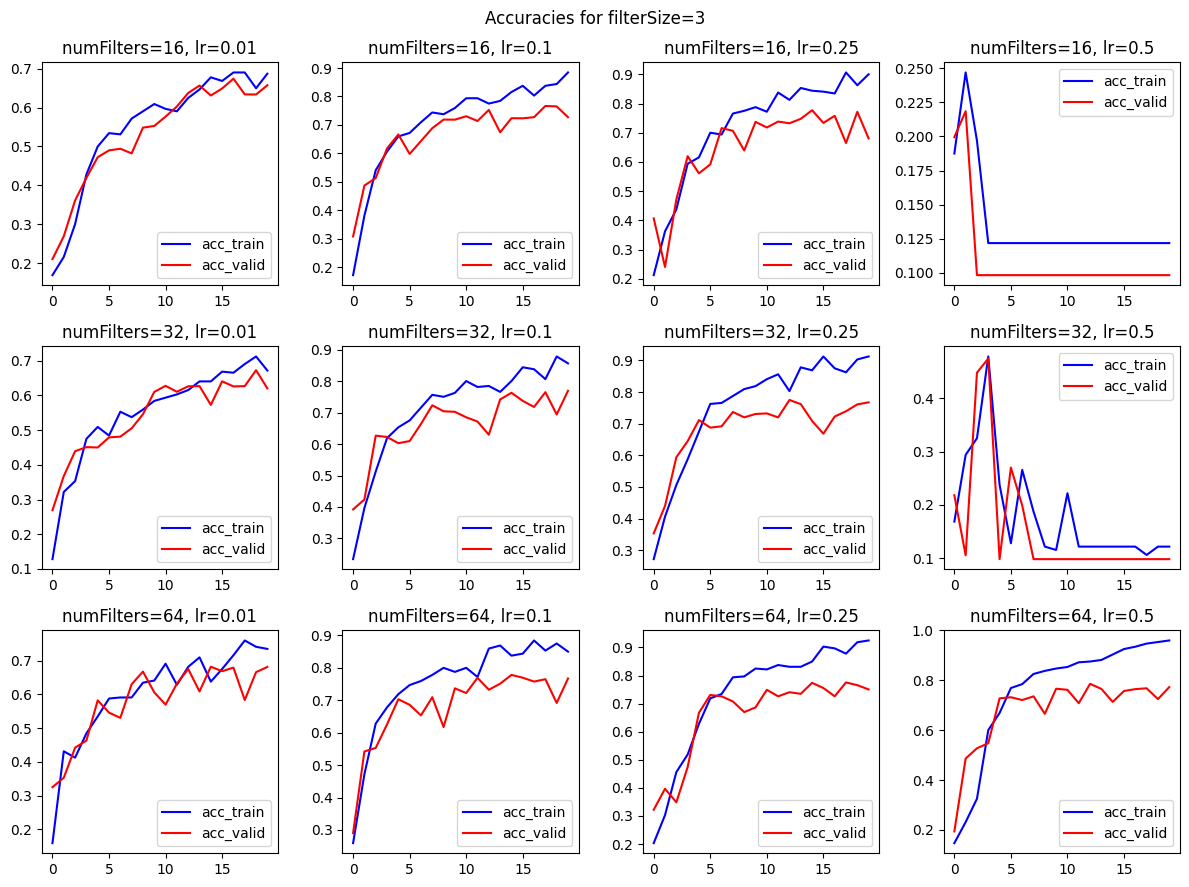

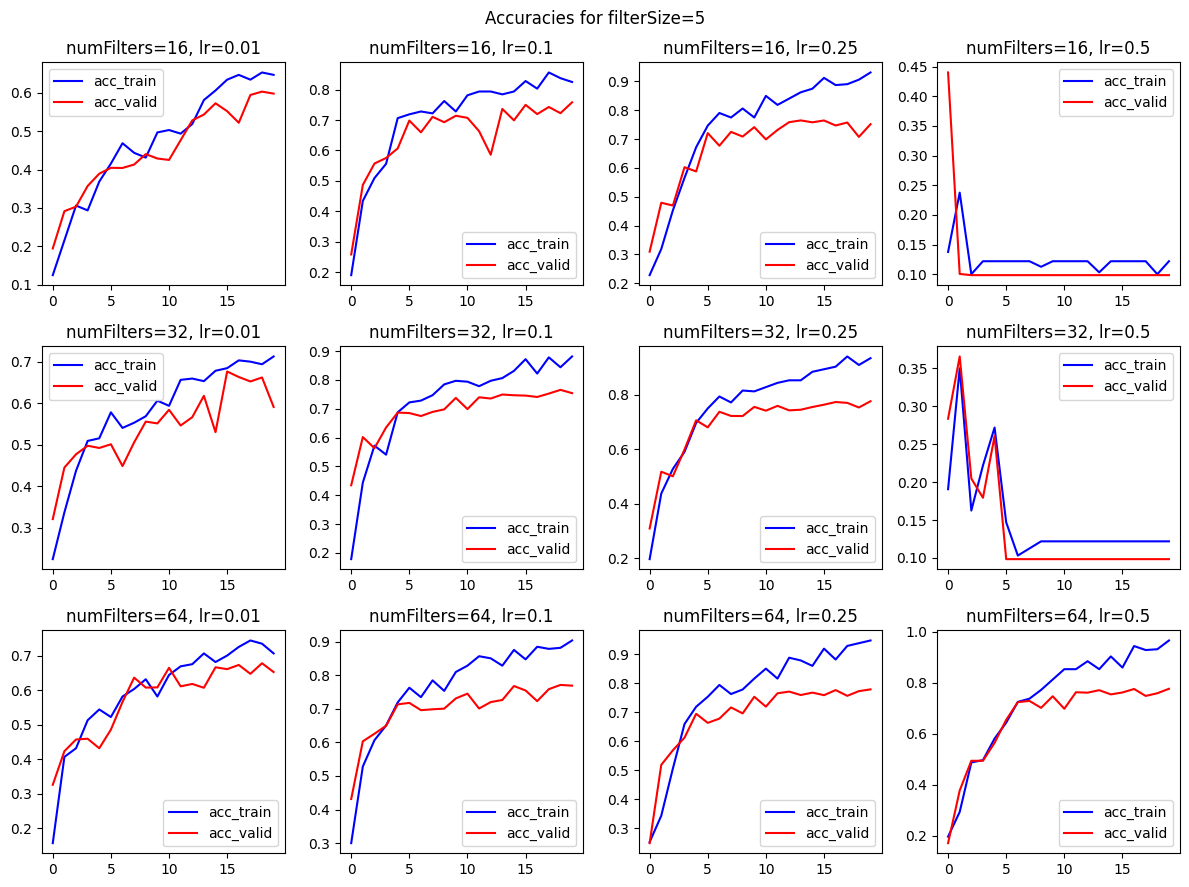

In [54]:
filterSize_grid = np.array([3, 5]).astype('int')
numFilters_grid = np.array([16, 32, 64]).astype('int')
lr_grid = np.array([0.01, 0.1, 0.25, 0.5])

nepochs=20

# Data loaders to provide mini-batches of samples
batchSize = 32 # chosen from last step

nbatches = 10  # small (but not tiny) sample
trainsize = nbatches*batchSize
training_data_subset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
training_loader = DataLoader(training_data_subset, batch_size=batchSize, shuffle=True) 
test_loader = DataLoader(validation_data, batch_size=batchSize, shuffle=True)

for filterSize in filterSize_grid:
    fig = plt.figure(figsize=(12,9), tight_layout=True)
    fig.suptitle("Accuracies for filterSize={}".format(filterSize))
    gs = GridSpec(3,4,fig)

    for i, numFilters in enumerate(numFilters_grid):
        for j, lr in enumerate(lr_grid):
            # train model with grid params
            model = cnn_model(
                filterSize=filterSize.item(), 
                numFilters=numFilters.item()
            )
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)

            _, _, acc_train, acc_valid = train_eval(model, optimizer, nepochs, training_loader, test_loader)

            fig.add_subplot(gs[i, j])
            plt.title("numFilters={}, lr={}".format(numFilters, lr))

            plt.plot(range(nepochs), acc_train, "b-", label="acc_train")
            plt.plot(range(nepochs), acc_valid, "r-", label="acc_valid")
            plt.legend()


- CNNs seems to get more robust w.r.t. high learning rates with higher number of filters
- The lower the learning rate, the higher the maximum accuracy (avoids ping-pong)
- slightly better performance with smaller 3x3 filters (images already very small, makes sense)
- lowest number of filters actually seems to show most pronounced continuing upwards trend, followed by 32
- train and validation curves separate more and more with increasing number of filters --> overfitting

Winning params:
- batch size=32
- filter size=3x3
- number of filters=16 (avoid overfitting and save on training time)
- learning rate=0.05   (compromise between 0.01 and 0.1)

#### Full Training

Now using full training set and winning params from grid search

In [56]:
# Params
nepochs = 50
batchSize = 32
lr = 0.05 
numFilters=16
filterSize=3

model = cnn_model(numFilters=numFilters, filterSize=filterSize) # reset model
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Data loaders to provide mini-batches of samples
training_loader = DataLoader(training_data, batch_size=batchSize, shuffle=True) 
test_loader = DataLoader(validation_data, batch_size=batchSize, shuffle=True)

cost_train, cost_valid, acc_train, acc_valid = train_eval(model, optimizer, nepochs, training_loader, test_loader)

Epoch 0: 0.018447, 0.788080, 0.014663, 0.837500
Epoch 1: 0.011956, 0.863160, 0.011616, 0.866800
Epoch 2: 0.010559, 0.880320, 0.010859, 0.878400
Epoch 3: 0.009792, 0.889020, 0.009505, 0.891400
Epoch 4: 0.009125, 0.896800, 0.011740, 0.865600
Epoch 5: 0.008736, 0.899740, 0.009167, 0.897100
Epoch 6: 0.008315, 0.904720, 0.010161, 0.886500
Epoch 7: 0.008054, 0.906620, 0.008598, 0.902500
Epoch 8: 0.007773, 0.910820, 0.009294, 0.896100
Epoch 9: 0.007580, 0.912320, 0.008813, 0.900400
Epoch 10: 0.007349, 0.917040, 0.010760, 0.878800
Epoch 11: 0.007153, 0.918560, 0.008997, 0.898300
Epoch 12: 0.007008, 0.919020, 0.008377, 0.907600
Epoch 13: 0.006780, 0.923000, 0.008445, 0.906500
Epoch 14: 0.006663, 0.923080, 0.008274, 0.906400
Epoch 15: 0.006509, 0.925300, 0.009466, 0.890800
Epoch 16: 0.006401, 0.925740, 0.008750, 0.903000
Epoch 17: 0.006223, 0.928320, 0.008322, 0.906700
Epoch 18: 0.006138, 0.928700, 0.008408, 0.905900
Epoch 19: 0.006027, 0.930000, 0.008164, 0.910100
Epoch 20: 0.005865, 0.930940, 

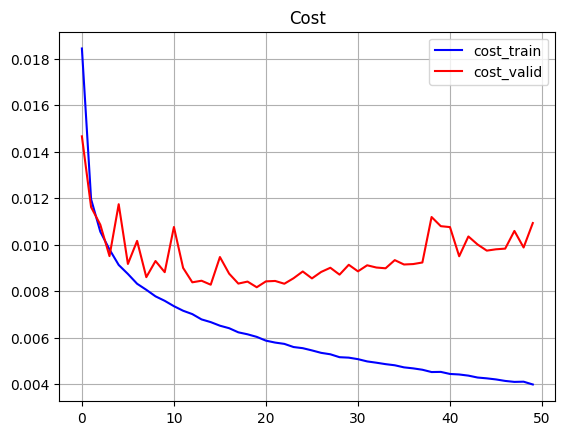

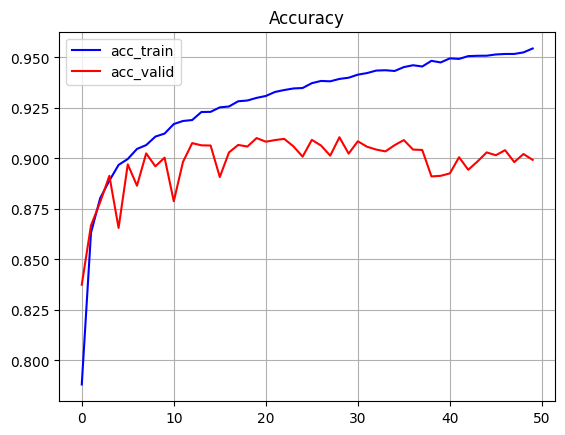

In [57]:
plt.figure(1)
plt.title("Cost")
plt.plot(range(nepochs), cost_train, "b-", label="cost_train")
plt.plot(range(nepochs), cost_valid, "r-", label="cost_valid")
plt.grid(True)
plt.legend()


plt.figure(2)
plt.title("Accuracy")
plt.plot(range(nepochs), acc_train, "b-", label="acc_train")
plt.plot(range(nepochs), acc_valid, "r-", label="acc_valid")
plt.grid(True)
plt.legend()

Training for more than the 20 epochs from before actually doesn't help all that much and leads to overfitting. We already train much more per epoch because the full training set is used in each epoch. 
Also cost starts increasing somehow?

### Cross-Validation

Use 5-fold cross validation to estimate the accuracy and an error bar of the accuracy estimate.

- Paying with almost 5x training time :/


In [60]:
# Params
nepochs = 20
batchSize = 32

lr = 0.05

model = cnn_model(numFilters=16,filterSize=3) # reset model
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [61]:
### YOUR CODE HERE ###
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)
folds_eval = []

for fold, (train_idx, test_idx) in enumerate(kf.split(training_data)):
    print(f"Fold {fold + 1}")
    # Data loaders to provide mini-batches of samples
    training_loader = DataLoader(
        training_data, 
        batch_size=batchSize, 
        sampler=torch.utils.data.SubsetRandomSampler(train_idx)
        ) 
    
    test_loader = DataLoader(
        training_data, 
        batch_size=batchSize, 
        sampler=torch.utils.data.SubsetRandomSampler(test_idx)
        ) 
    
    model = cnn_model()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

    folds_eval.append(train_eval(model, optimizer, nepochs, training_loader, test_loader))
    #(cost_train, cost_valid, acc_train, acc_valid) = train_eval(model, optimizer, nepochs, training_loader, test_loader)


Epoch 0: 0.014993, 0.629680, 0.002793, 0.169180
Epoch 1: 0.009608, 0.690740, 0.002328, 0.173640
Epoch 2: 0.008454, 0.703540, 0.002144, 0.176400
Epoch 3: 0.007809, 0.711220, 0.002007, 0.177500
Epoch 4: 0.007322, 0.716300, 0.001987, 0.178080
Epoch 5: 0.006900, 0.721040, 0.001834, 0.179580
Epoch 6: 0.006577, 0.724820, 0.001845, 0.179260
Epoch 7: 0.006308, 0.727040, 0.001814, 0.179940
Epoch 8: 0.006025, 0.731060, 0.001812, 0.179200
Epoch 9: 0.005761, 0.733860, 0.001670, 0.181500
Epoch 10: 0.005590, 0.735220, 0.001790, 0.179380
Epoch 11: 0.005353, 0.738260, 0.001687, 0.180880
Epoch 12: 0.005190, 0.739760, 0.001704, 0.181320
Epoch 13: 0.005021, 0.741780, 0.001619, 0.181880
Epoch 14: 0.004815, 0.744680, 0.001708, 0.181360
Epoch 15: 0.004647, 0.746600, 0.001749, 0.180220
Epoch 16: 0.004468, 0.747840, 0.001645, 0.182000
Epoch 17: 0.004317, 0.750840, 0.001633, 0.182280
Epoch 18: 0.004158, 0.753040, 0.001626, 0.182240
Epoch 19: 0.004059, 0.753640, 0.001640, 0.182480
Epoch 0: 0.015029, 0.628480, 0

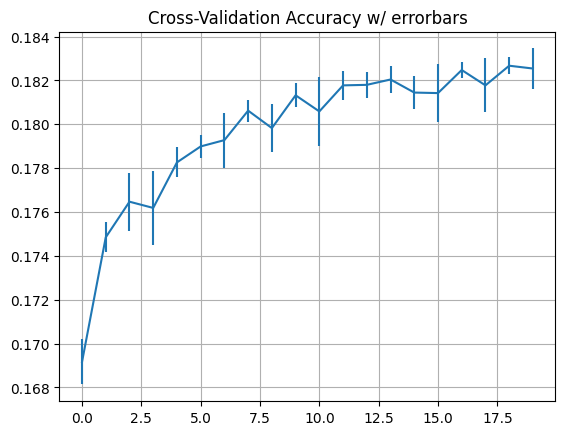

In [62]:
# calculate mean and std across folds
acc_val = np.array(folds_eval)[:,-1,:]
mean = np.mean(acc_val, axis=0)
std = np.std(acc_val, axis=0)

# plot errorbars
plt.figure()
plt.title("Cross-Validation Accuracy w/ errorbars")
plt.errorbar(range(nepochs), mean, yerr=std)
plt.grid(True)


Not sure why validation accuracy is in the toilet..

### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. *SGD*: Refer to the results from above - for later comparison.
<br>

2. *Momentum*: Play with at least three different settings when using momentum: 
    - learning rate
    - momentum parameter
    - Nesterov flag.
    
    Start with momentum=0.9 without Nesterov and suitable learning rate.
    
    Then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?
<br>

3. *RMSProp*: Same thing now for RMSprop (without momentum). Play with at least three different settings when using RMSprop: 
    - lr
    - alpha

    Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?<br>
<br>

4. *Adam*: Same thing now for Adam. Play with at least three different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?<br>
<br>


In [67]:
nbatch = 64
nepochs = 20

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

#### 2. Momentum

In [ ]:
lr_grid = np.array([0.05, 0.02, 0.01])
momentum_grid = np.array([0.9, 0.5, 0.1])

fig_cost = plt.figure(figsize=(10,10), tight_layout=True)
fig_cost.suptitle("Costs")
gs_cost = GridSpec(3,3,fig_cost)

fig_acc = plt.figure(figsize=(10,10), tight_layout=True)
fig_acc.suptitle("Accuracies")
gs_acc = GridSpec(3,3,fig_acc)


for i, lr in enumerate(lr_grid):
    for j, momentum in enumerate(momentum_grid):
        # train model with grid params
        model = cnn_model(numFilters=16, filterSize=3)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        cost_train, cost_valid, acc_train, acc_valid = train_eval(model, optimizer, nepochs, training_loader, test_loader)

        ax_cost = fig_cost.add_subplot(gs_cost[i, j])
        ax_cost.set_title("lr={}, momentum={}".format(lr, momentum))
        # plt.title("lr={}, momentum={}".format(lr, momentum))
        ax_cost.plot(range(nepochs), cost_train, "b-", label="cost_train")
        ax_cost.plot(range(nepochs), cost_valid, "r-", label="cost_valid")
        
        ax_acc = fig_acc.add_subplot(gs_acc[i, j])
        ax_acc.set_title("lr={}, momentum={}".format(lr, momentum))
        ax_acc.plot(range(nepochs), acc_train, "b-", label="acc_train")
        ax_acc.plot(range(nepochs), acc_valid, "r-", label="acc_valid")
    


low-to-medium values for both learning rate and momentum work best.

Winning params:
- lr=0.02
- momentum=0.5

Using winning params from above and comparing to `nesterov=True`

In [ ]:
# Params
nepochs=20
batchSize=32
lr=0.02
momentum=0.5 
numFilters=16
filterSize=3

model = cnn_model(numFilters=numFilters, filterSize=filterSize) # reset model
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)

# Data loaders to provide mini-batches of samples
training_loader = DataLoader(training_data, batch_size=batchSize, shuffle=True) 
test_loader = DataLoader(validation_data, batch_size=batchSize, shuffle=True)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.5)
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, optimizer, nepochs, training_loader, test_loader)

# plot
plt.figure(1)
plt.title("Cost")
plt.plot(range(nepochs), cost_train, "b-", label="cost_train")
plt.plot(range(nepochs), cost_valid, "r-", label="cost_valid")
plt.grid(True)
plt.legend()


plt.figure(2)
plt.title("Accuracy")
plt.plot(range(nepochs), acc_train, "b-", label="acc_train")
plt.plot(range(nepochs), acc_valid, "r-", label="acc_valid")
plt.grid(True)
plt.legend()

The Nesterov modification is meant to be slightly more efficient, but in this example, it seems slightly worse in performance while also not being significantly faster to compute

#### 3. RMSProp

In [84]:
nbatch = 64
nepochs = 20

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

## use for quick training
# nbatches = 10  # small (but not tiny) sample
# trainsize = nbatches*batchSize
# training_data_subset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
# training_loader = DataLoader(training_data_subset, batch_size=batchSize, shuffle=True) 
# test_loader = DataLoader(validation_data, batch_size=batchSize, shuffle=True)

Epoch 0: 0.008596, 0.825640, 0.006675, 0.842100
Epoch 1: 0.005595, 0.870300, 0.007306, 0.846300
Epoch 2: 0.005107, 0.880980, 0.005979, 0.864200
Epoch 3: 0.004815, 0.888700, 0.004981, 0.884400
Epoch 4: 0.004613, 0.892800, 0.006242, 0.852400
Epoch 5: 0.004515, 0.893460, 0.004960, 0.883300
Epoch 6: 0.004405, 0.897360, 0.005389, 0.878700
Epoch 7: 0.004339, 0.898140, 0.005558, 0.871000
Epoch 8: 0.004312, 0.898260, 0.005473, 0.874800
Epoch 9: 0.004245, 0.900580, 0.005760, 0.868700
Epoch 10: 0.004218, 0.899480, 0.005371, 0.878700
Epoch 11: 0.004182, 0.901320, 0.004981, 0.890900
Epoch 12: 0.004159, 0.901520, 0.005292, 0.880900
Epoch 13: 0.004160, 0.901500, 0.006730, 0.865000
Epoch 14: 0.004152, 0.901020, 0.005627, 0.876400
Epoch 15: 0.004077, 0.902640, 0.006595, 0.860100
Epoch 16: 0.004093, 0.904440, 0.007012, 0.849800
Epoch 17: 0.004064, 0.903860, 0.005537, 0.876500
Epoch 18: 0.004030, 0.904800, 0.005141, 0.889900
Epoch 19: 0.003998, 0.903740, 0.005376, 0.887700
Epoch 0: 0.010639, 0.786400, 0

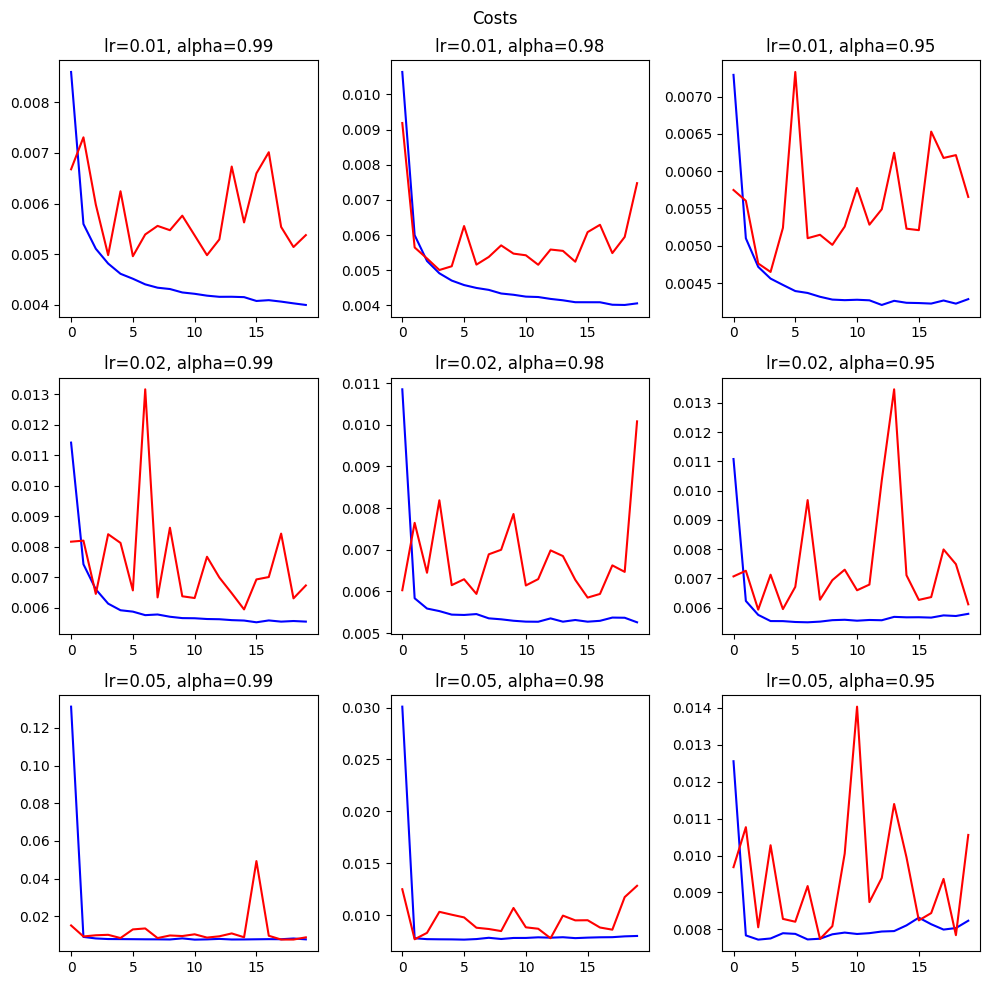

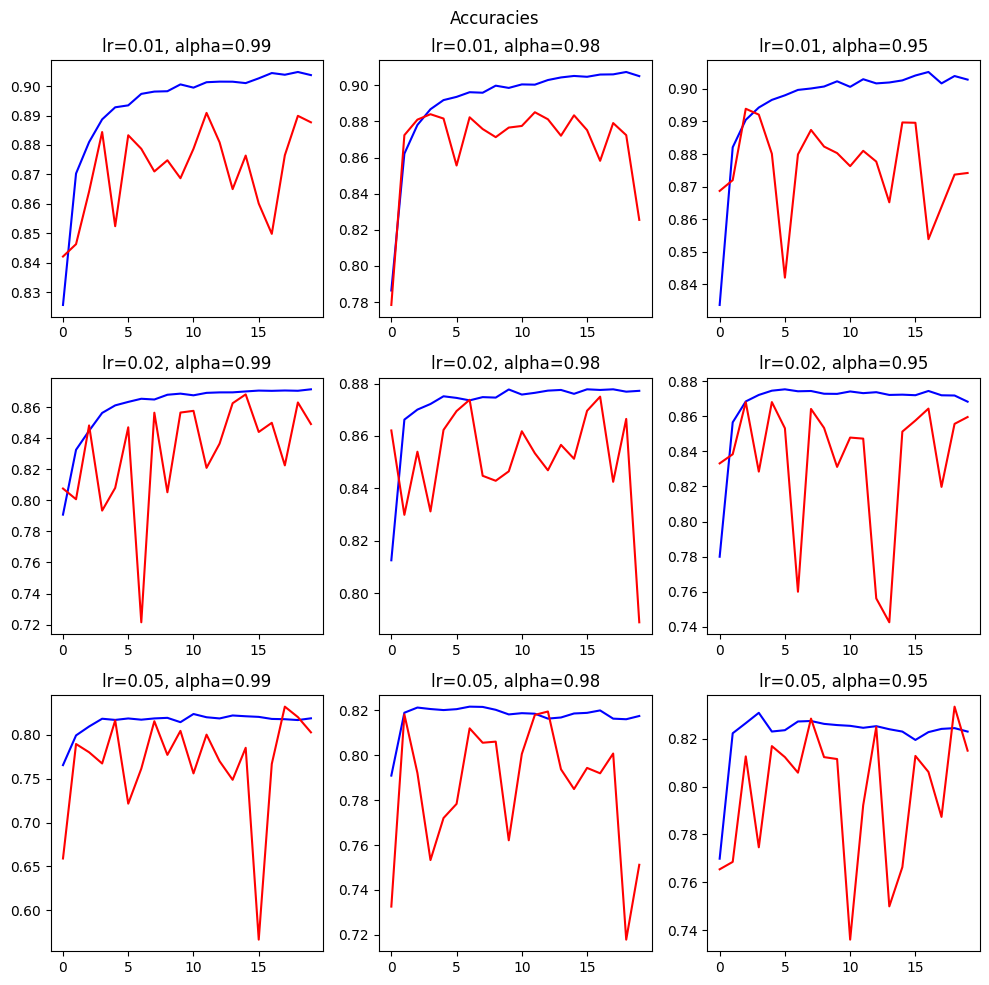

In [85]:
lr_grid = np.array([0.01, 0.02, 0.05]) 
alpha_grid = np.array([0.99, 0.98, 0.95])

fig_cost = plt.figure(figsize=(10,10), tight_layout=True)
fig_cost.suptitle("Costs")
gs_cost = GridSpec(3,3,fig_cost)

fig_acc = plt.figure(figsize=(10,10), tight_layout=True)
fig_acc.suptitle("Accuracies")
gs_acc = GridSpec(3,3,fig_acc)

for i, lr in enumerate(lr_grid):
    for j, alpha in enumerate(alpha_grid):
        # train model with grid params
        model = cnn_model(numFilters=16, filterSize=3)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=alpha)

        cost_train, cost_valid, acc_train, acc_valid = train_eval(model, optimizer, nepochs, training_loader, test_loader)

        ax_cost = fig_cost.add_subplot(gs_cost[i, j])
        ax_cost.set_title("lr={}, alpha={}".format(lr, alpha))
        ax_cost.plot(range(nepochs), cost_train, "b-", label="cost_train")
        ax_cost.plot(range(nepochs), cost_valid, "r-", label="cost_valid")
        
        ax_acc = fig_acc.add_subplot(gs_acc[i, j])
        ax_acc.set_title("lr={}, alpha={}".format(lr, alpha))
        ax_acc.plot(range(nepochs), acc_train, "b-", label="acc_train")
        ax_acc.plot(range(nepochs), acc_valid, "r-", label="acc_valid")

- Cost curves look quite wiggly, but deceivingly low scale on the axes. Remarkably low cost from the get-go. 
- Accuracy curves are actually very wiggly. Even lower lr would be worth trying but will see if alleviated by lr-scheduling later on instead of re-running.

Using winning params from above (lr=0.02, alpha=0.99) grid-search and comparing to `centered=True`

Epoch 0: 0.015148, 0.836680, 0.012525, 0.857500
Epoch 1: 0.010778, 0.874200, 0.010440, 0.879500
Epoch 2: 0.010150, 0.882220, 0.010944, 0.876300
Epoch 3: 0.009901, 0.883680, 0.010307, 0.880900
Epoch 4: 0.009704, 0.887500, 0.010396, 0.880700
Epoch 5: 0.009653, 0.887940, 0.010976, 0.875500
Epoch 6: 0.009604, 0.887500, 0.011515, 0.869000
Epoch 7: 0.009536, 0.888800, 0.010741, 0.879400
Epoch 8: 0.009525, 0.889120, 0.010836, 0.876100
Epoch 9: 0.009470, 0.889440, 0.010573, 0.878200
Epoch 10: 0.009379, 0.890040, 0.011221, 0.874100
Epoch 11: 0.009390, 0.890300, 0.010586, 0.879100
Epoch 12: 0.009379, 0.890960, 0.010557, 0.877500
Epoch 13: 0.009406, 0.890700, 0.012062, 0.858000
Epoch 14: 0.009396, 0.889980, 0.010619, 0.881000
Epoch 15: 0.009383, 0.890940, 0.012981, 0.854100
Epoch 16: 0.009376, 0.890700, 0.011024, 0.873200
Epoch 17: 0.009357, 0.890560, 0.011417, 0.877300
Epoch 18: 0.009311, 0.890180, 0.011126, 0.879600
Epoch 19: 0.009282, 0.892360, 0.011760, 0.868500
Epoch 20: 0.009350, 0.892440, 

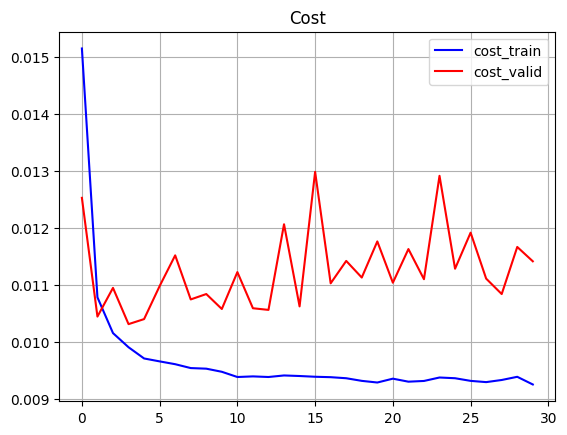

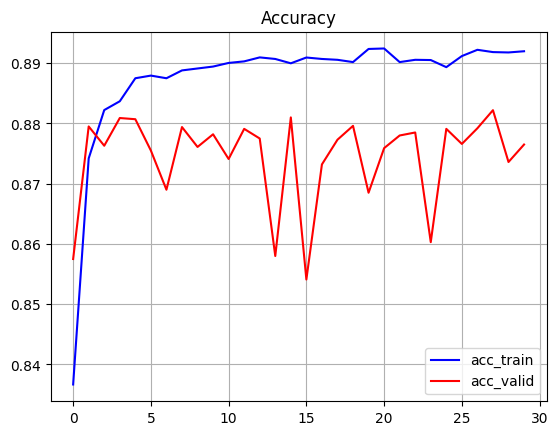

In [89]:
# Params
nepochs=30
batchSize=32
lr=0.01
numFilters=16
filterSize=3

model = cnn_model(numFilters=numFilters, filterSize=filterSize) # reset model
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, centered=True)

# Data loaders to provide mini-batches of samples
training_loader = DataLoader(training_data, batch_size=batchSize, shuffle=True) 
test_loader = DataLoader(validation_data, batch_size=batchSize, shuffle=True)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.5)
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, optimizer, nepochs, training_loader, test_loader)

# plot
plt.figure(1)
plt.title("Cost")
plt.plot(range(nepochs), cost_train, "b-", label="cost_train")
plt.plot(range(nepochs), cost_valid, "r-", label="cost_valid")
plt.grid(True)
plt.legend()


plt.figure(2)
plt.title("Accuracy")
plt.plot(range(nepochs), acc_train, "b-", label="acc_train")
plt.plot(range(nepochs), acc_valid, "r-", label="acc_valid")
plt.grid(True)
plt.legend()

**centered**: "If True, compute the centered RMSProp, the gradient is normalized by an estimation of its variance" --> mean-less version

observable effect:
- slightly higher validation cost
- slightly less eratic validation accuracy

--> would recommend using centered option


#### 4. Adam

Epoch 0: 0.008844, 0.797660, 0.006107, 0.864500
Epoch 1: 0.005621, 0.871920, 0.006055, 0.859900
Epoch 2: 0.004969, 0.888320, 0.004942, 0.890300
Epoch 3: 0.004568, 0.895800, 0.004522, 0.899900
Epoch 4: 0.004277, 0.902120, 0.004406, 0.899500
Epoch 5: 0.003988, 0.908120, 0.004237, 0.903600
Epoch 6: 0.003801, 0.912500, 0.004574, 0.898200
Epoch 7: 0.003603, 0.916520, 0.004052, 0.907600
Epoch 8: 0.003455, 0.919220, 0.004057, 0.908200
Epoch 9: 0.003301, 0.923740, 0.003935, 0.912300
Epoch 10: 0.003181, 0.925300, 0.003877, 0.912000
Epoch 11: 0.003064, 0.928300, 0.004100, 0.906100
Epoch 12: 0.002955, 0.931600, 0.003852, 0.911200
Epoch 13: 0.002889, 0.932240, 0.004099, 0.908500
Epoch 14: 0.002768, 0.935280, 0.004061, 0.908900
Epoch 15: 0.002702, 0.937280, 0.003801, 0.913100
Epoch 16: 0.002630, 0.938600, 0.003878, 0.912800
Epoch 17: 0.002551, 0.941680, 0.003891, 0.913100
Epoch 18: 0.002458, 0.943520, 0.003982, 0.910200
Epoch 19: 0.002427, 0.943320, 0.003921, 0.913600
Epoch 20: 0.002372, 0.945420, 

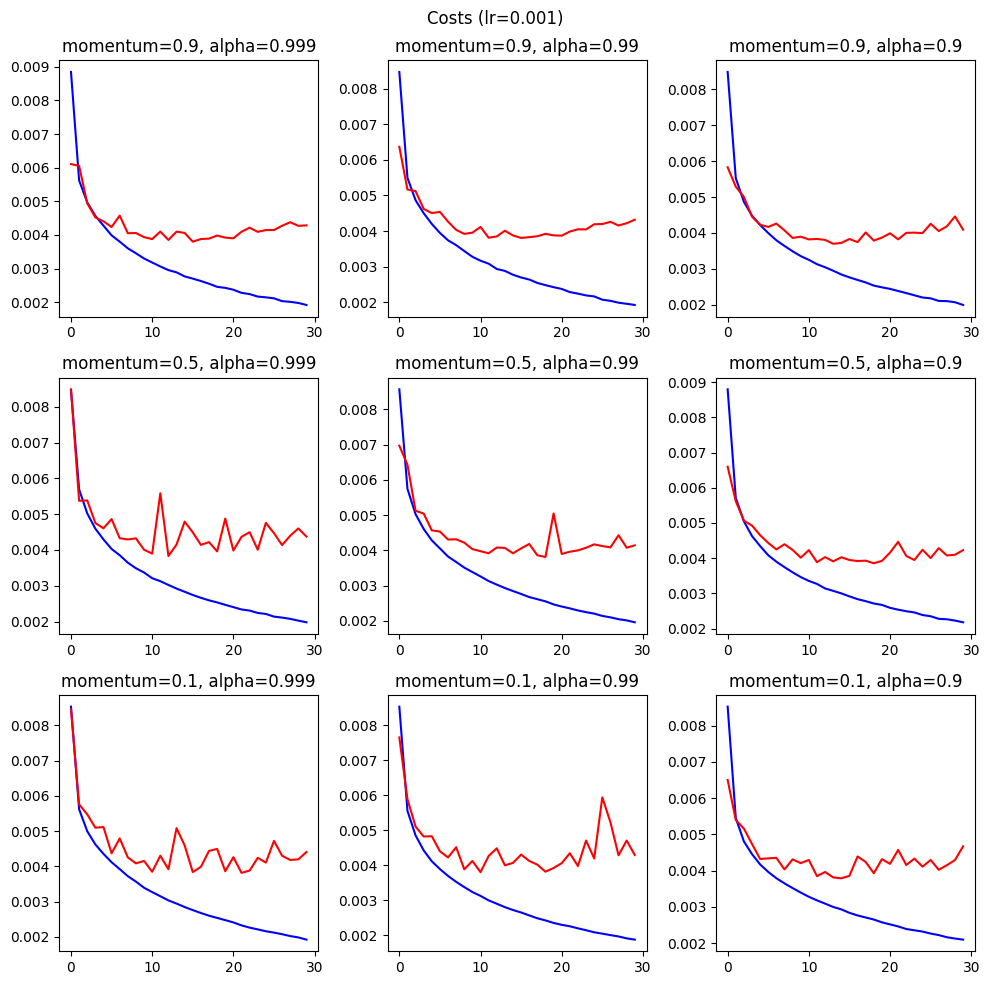

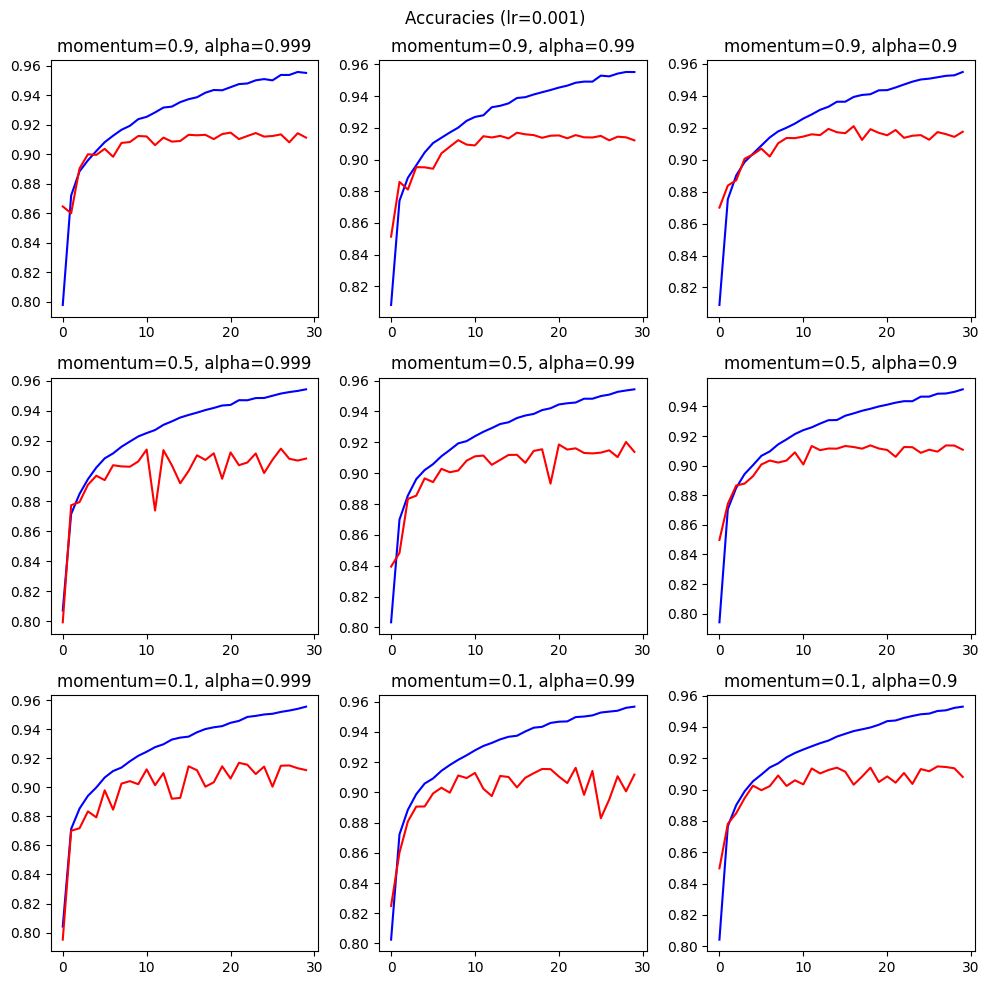

In [95]:
nbatch = 64
nepochs = 30

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

# # use for quick training
# nbatches = 10  # small (but not tiny) sample
# trainsize = nbatches*batchSize
# training_data_subset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
# training_loader = DataLoader(training_data_subset, batch_size=batchSize, shuffle=True) 
# test_loader = DataLoader(validation_data, batch_size=batchSize, shuffle=True)

# finer grid search
lr = 0.001 # default
momentum_grid = np.array([0.9, 0.5, 0.1]) # beta1
alpha_grid = np.array([0.999, 0.99, 0.9]) # beta2

# train and plot
fig_cost = plt.figure(figsize=(10,10), tight_layout=True)
fig_cost.suptitle("Costs (lr={})".format(lr))
gs_cost = GridSpec(3,3,fig_cost)

fig_acc = plt.figure(figsize=(10,10), tight_layout=True)
fig_acc.suptitle("Accuracies (lr={})".format(lr))
gs_acc = GridSpec(3,3,fig_acc)

for i, momentum in enumerate(momentum_grid):
    for j, alpha in enumerate(alpha_grid):
        # train model with grid params
        model = cnn_model(numFilters=16, filterSize=3)

        betas = (momentum, alpha)
        optimizer = torch.optim.Adam(model.parameters(), lr, betas)

        cost_train, cost_valid, acc_train, acc_valid = train_eval(model, optimizer, nepochs, training_loader, test_loader)

        ax_cost = fig_cost.add_subplot(gs_cost[i, j])
        ax_cost.set_title("momentum={}, alpha={}".format(momentum, alpha))
        ax_cost.plot(range(nepochs), cost_train, "b-", label="cost_train")
        ax_cost.plot(range(nepochs), cost_valid, "r-", label="cost_valid")
        
        ax_acc = fig_acc.add_subplot(gs_acc[i, j])
        ax_acc.set_title("momentum={}, alpha={}".format(momentum, alpha))
        ax_acc.plot(range(nepochs), acc_train, "b-", label="acc_train")
        ax_acc.plot(range(nepochs), acc_valid, "r-", label="acc_valid")

- Adam is remarkably consistent across different parameter values. The default params do a very good job. 
- Quickly reaches 90% accuracy within 10 epochs

### Plots and Comments (for the different steps described above) 
Plots: see above.

#### Momentum recommended best params
- lr=0.02
- momentum=0.5
- nesterov=False
- nepochs=30

#### RMSprop recommended best params
- lr=0.01 (makes sense, that lr can be decreased, as rmsprop tends more directly to minimum)
- alpha=0.99 (default, seems to be the most stable and lowest average cost)
- centered=True
- nepochs=30

#### Adam recommended best params
default params:
- lr=0.001
- beta1=0.9
- beta2=0.999
- nepochs=10


### Learning Rate Schedule

Modify your `train_eval` method implemented above to support using a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task?

Compare and evaluate the training performance with the results obtained for the different optimizers above and provide a judgement.

In [17]:
# Params
nepochs = 20
batchSize = 32
lr = 0.1        # large initial lr 
numFilters=16
filterSize=3

model = cnn_model(numFilters=numFilters, filterSize=filterSize) # reset model
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Data loaders to provide mini-batches of samples
training_loader = DataLoader(training_data, batch_size=batchSize, shuffle=True) 
test_loader = DataLoader(validation_data, batch_size=batchSize, shuffle=True)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.25)
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, optimizer, nepochs, training_loader, test_loader, scheduler)

Epoch 0: 0.016470, 0.812540, 0.011822, 0.862900
Epoch 1: 0.010752, 0.878100, 0.012139, 0.858200
Epoch 2: 0.009402, 0.893300, 0.010031, 0.885700
Epoch 3: 0.008675, 0.901740, 0.009618, 0.886400
Epoch 4: 0.008082, 0.907120, 0.008512, 0.901900
Epoch 5: 0.006821, 0.922480, 0.008252, 0.904300
Epoch 6: 0.006607, 0.925480, 0.008150, 0.904500
Epoch 7: 0.006471, 0.927000, 0.008009, 0.908900
Epoch 8: 0.006338, 0.928580, 0.007988, 0.906500
Epoch 9: 0.006222, 0.929740, 0.007942, 0.907300
Epoch 10: 0.005857, 0.934620, 0.007895, 0.908200
Epoch 11: 0.005806, 0.935200, 0.007807, 0.909300
Epoch 12: 0.005770, 0.934940, 0.007768, 0.911000
Epoch 13: 0.005733, 0.935400, 0.007821, 0.910900
Epoch 14: 0.005698, 0.936180, 0.007857, 0.911200
Epoch 15: 0.005594, 0.937300, 0.007785, 0.909700
Epoch 16: 0.005581, 0.937840, 0.007794, 0.910700
Epoch 17: 0.005570, 0.938280, 0.007766, 0.911100
Epoch 18: 0.005562, 0.937860, 0.007790, 0.910100
Epoch 19: 0.005558, 0.937960, 0.007767, 0.911400


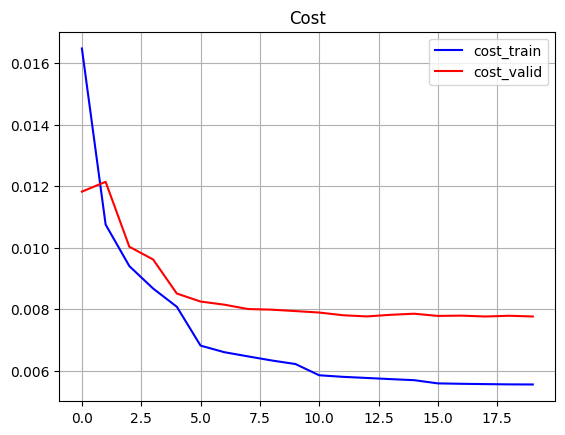

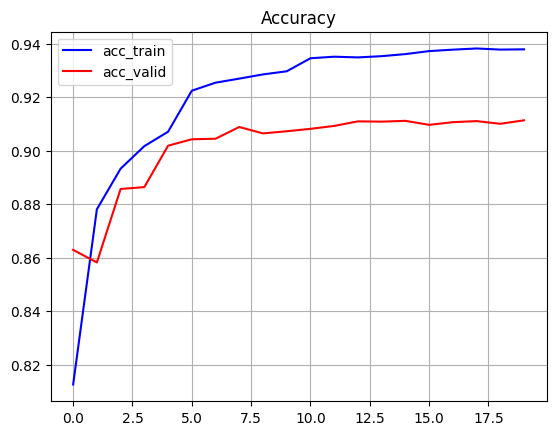

In [19]:
# plot
plt.figure(1)
plt.title("Cost")
plt.plot(range(nepochs), cost_train, "b-", label="cost_train")
plt.plot(range(nepochs), cost_valid, "r-", label="cost_valid")
plt.grid(True)
plt.legend()


plt.figure(2)
plt.title("Accuracy")
plt.plot(range(nepochs), acc_train, "b-", label="acc_train")
plt.plot(range(nepochs), acc_valid, "r-", label="acc_valid")
plt.grid(True)
plt.legend()

**Recommended params:**
- lr = 0.1
- stepsize = 5
- gamma = 0.25

#### Judgement
**PRO:**
- Significant improvement over vanilla SGD, similar performance to Adam with right parameters
- Smooth curves, very stable
- Easy to see what's going on, simple

**Con:**
- Has to be tuned manually, whereas Adam "just works" with default params most of the time